In [1]:
%load_ext rpy2.ipython

In [2]:
%%R
source("likelihoodFunctionCC.R")
source("TADAaddEvidence.R")
mu.frac <- c(0.074, 0.32)
gamma.mean.dn <- c(20, 4.7)
beta.dn <- c(1,1)
gamma.mean.CC <- c(2.3, 1.00)
beta.CC <- c(4.0, 1000)
rho1 <- c(0.1, 0.5)
nu1 <- c(200, 100)
rho0 <- c(0.1, 0.5)
nu0 <- c(200, 100)
hyperpar <- as.array(rbind(gamma.mean.dn, beta.dn, gamma.mean.CC, beta.CC, rho1, nu1, rho0, nu0))
l <- 100
pi0 <- 0.94 # the fraction of non-risk genes

# ASC (Autism Sequencing Consortium) data
# The file name contains the sample size information
# The only relevant counts are dn.LoF and dn.mis3
data <- read.csv("TADA/data/ASC_2231trios_1333trans_1601cases_5397controls.csv", header=TRUE, as.is=TRUE)
ntrio <- 2231  # number of trios
ncase <- 1601  # number of cases
nctrl <- 5397  # number of controls
ntrans <- 1333 # number of subjects with transmission data
N <- list(dn=ntrio, ca=ntrans+ncase, cn=ntrans+nctrl)

# Running TADA
counts <- as.array(cbind(data$dn.LoF, data$case.LoF+data$trans.LoF, data$ctrl.LoF+data$ntrans.LoF, data$dn.mis3, data$case.mis3+data$trans.mis3,
 data$ctrl.mis3+data$ntrans.mis3))


count.mu.Data <- cbind(counts[, 1:3], data$mut.rate*mu.frac[1])
#count.mu.Data <- cbind(counts[, 4:6], data$mut.rate*mu.frac[2])

########Calculate data.frame and likelihood function
##countData should be a data.frame including all annotation types.
#Each type includes 3 columns: de novo, case and control
#mutData: a data.frame including mutation rates of each type


###Re-write the likelihood function

In [3]:
%%R

logLikelihood <- function(countData, hyperpar, pi0 = 0.06, mutationData,
                          testType = c("dn", "CaseControl", "both"), nCore = 1, combinationType = 1){
    ##Identify how many annotation types
    if (is.numeric(mutationData))
        mutationData <- cbind(mutationData)
    kk <- dim(mutationData)[2]

        ###Choose only de novo (dn), only cc (cc), or both ("both")
        testType <- match.arg(testType)

    message("testType: ", testType)

    dataOut <- NULL

    logLLKallType <- 0

    for (jj in 1:kk){

        ##Extract each annotation
        sIndex <- 3*(jj - 1) + 1

        countData.type <- cbind(countData[, c(sIndex, sIndex + 1, sIndex + 2)], mutationData[, jj])

#        print(dim(countData.type))

        typeData <- apply(countData.type, 1, function(xRow){
            x <- list(dn = xRow[1],
                    ca = xRow[2], cn = xRow[3], mu = xRow[4])

 #           print(xRow)
                #####Alternative hypothesis
                x.alt.CC <- evidence.alt.CC(x = x, N = N, gamma.mean = hyperpar[3, jj],
                                            beta = hyperpar[4, jj],
                                            rho1 = hyperpar[5, jj], nu1 = hyperpar[6, jj])$total

                x.alt.dn <- dnbinom(x = x$dn, hyperpar[1, jj]*hyperpar[2, jj],
                                   hyperpar[2, jj]/(hyperpar[2, jj] + 2*N$dn*x$mu))
                    #evidence.alt.dn(x = xRow[1], N = N$dn, mu = xRow[4],
                     #                       gamma.mean = hyperpar[1, 1], beta = hyperpar[2, 1])

#####Null hypothesis

                x.null.CC <- evidence.null.CC(x = x, N = N, rho0 = hyperpar[7, jj], nu0 = hyperpar[8, jj])$total
                x.null.dn <- dpois(x$dn, 2*N$dn*x$mu) #evidence.null.dn(x = xRow[1], N = N$dn, mu = xRow[4])


            return(c(x.alt.CC, x.alt.dn, x.null.CC, x.null.dn))

        })

        #########Done

        ##############################################
                    ##########Calculate log likelihood
        typeData <- t(typeData)

            pH1.dn <- typeData[, 2]
            pH0.dn <- typeData[, 4]

        pH1.cc <- typeData[, 1]
        pH0.cc <- typeData[, 3]

        if (testType == "dn"){
            pH1 <- pi0*pH1.dn
            pH0 <- (1 - pi0)*pH0.dn
        }
        if (testType == "CaseControl"){
            pH1 <- pi0*pH1.cc
            pH0 <- (1 - pi0)*pH0.cc
        }

        if (testType == "both") {
            pH1 <- pi0*pH1.cc*pH1.dn
            pH0 <- (1- pi0)*pH0.cc*pH0.dn
        }
            pAll <- pH1 + pH0

            #sum(log(pAll))

            log.pAll <- sum(log(pAll[!is.na(pAll)]))#log(prod(pAll))


        dataOut <- cbind(dataOut, typeData)

            logLLKallType <- logLLKallType + log.pAll


    }


    return(list(dataOut = dataOut, logLik = logLLKallType))
}




###Likelihood for de novo LoF only

In [ ]:
%%R
piSeq <- seq(0.001, 0.07, 0.002)
library('parallel')

llkout <- mclapply(piSeq, function(piX) logLikelihood(countData = counts, hyperpar = hyperpar,
                                      pi0 = piX, mutationData = data$mut.rate*mu.frac[1], 
                                                   testType = "dn")$logLik)
                 


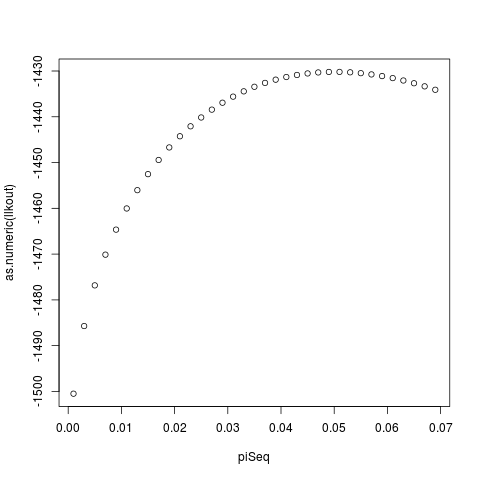

In [7]:
%%R
llkout
plot(piSeq, as.numeric(llkout))



In [11]:
%%R
piSeq.cc <- seq(0.0000001, 0.0001, 0.0000001)


llkout.cc <- mclapply(piSeq.cc, function(piX) logLikelihood(countData = counts, hyperpar = hyperpar,
                                      pi0 = piX, mutationData = data$mut.rate*mu.frac[1], 
                                                   testType = "CaseControl")$logLik)
                 
llkout.cc

[[1]]
[1] -67733.58

[[2]]
[1] -67733.58

[[3]]
[1] -67733.58

[[4]]
[1] -67733.58

[[5]]
[1] -67733.58

[[6]]
[1] -67733.58

[[7]]
[1] -67733.59

[[8]]
[1] -67733.59

[[9]]
[1] -67733.59

[[10]]
[1] -67733.59

[[11]]
[1] -67733.59

[[12]]
[1] -67733.59

[[13]]
[1] -67733.59

[[14]]
[1] -67733.59

[[15]]
[1] -67733.59

[[16]]
[1] -67733.59

[[17]]
[1] -67733.59

[[18]]
[1] -67733.59

[[19]]
[1] -67733.59

[[20]]
[1] -67733.59

[[21]]
[1] -67733.59

[[22]]
[1] -67733.59

[[23]]
[1] -67733.59

[[24]]
[1] -67733.59

[[25]]
[1] -67733.59

[[26]]
[1] -67733.59

[[27]]
[1] -67733.59

[[28]]
[1] -67733.59

[[29]]
[1] -67733.59

[[30]]
[1] -67733.59

[[31]]
[1] -67733.59

[[32]]
[1] -67733.59

[[33]]
[1] -67733.59

[[34]]
[1] -67733.59

[[35]]
[1] -67733.59

[[36]]
[1] -67733.59

[[37]]
[1] -67733.59

[[38]]
[1] -67733.59

[[39]]
[1] -67733.59

[[40]]
[1] -67733.59

[[41]]
[1] -67733.59

[[42]]
[1] -67733.59

[[43]]
[1] -67733.59

[[44]]
[1] -67733.59

[[45]]
[1] -67733.59

[[46]]
[1] -67733.5

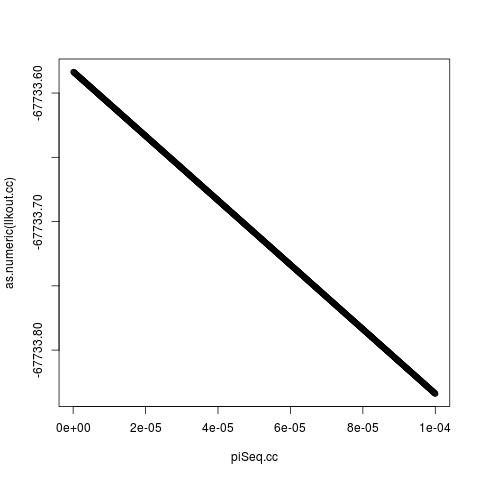

In [12]:
%%R
plot(piSeq.cc, as.numeric(llkout.cc))

###Cannnot see the optimal point for case-control data, use an analytic way

####Write a function to calculate the optimal values

In [23]:
%%R

piFunc.cc <- function(x){

    piX <- x[1]
    
    hyperparNew <- hyperpar
    
    log.All <- -logLikelihood(countData = counts, hyperpar = hyperparNew,
                              pi0 = piX,
                              mutationData = mutationData,
                              testType = "cc")$logLik
    return(log.All)
}


In [24]:
%%R
mutationData <- data$mut.rate*mu.frac[1]
pi.M.cc <- optimize(f = piFunc.cc, interval = c(0, 1))

In [25]:
%%R
pi.M.cc

$minimum
[1] 6.610696e-05

$objective
[1] 67733.75



In [40]:
%%R

tt <- pi.M.cc$minimum
piSeq.cc <- seq(0.000001, 0.0001, by = 0.000005)


llkout.cc <- lapply(piSeq.cc, function(piX) logLikelihood(countData = counts, hyperpar = hyperpar,
                                      pi0 = piX, mutationData = data$mut.rate*mu.frac[1], 
                                                   testType = "cc")$logLik)
                 

In [41]:
%%R
piSeq.cc

 [1] 1.0e-06 6.0e-06 1.1e-05 1.6e-05 2.1e-05 2.6e-05 3.1e-05 3.6e-05 4.1e-05
[10] 4.6e-05 5.1e-05 5.6e-05 6.1e-05 6.6e-05 7.1e-05 7.6e-05 8.1e-05 8.6e-05
[19] 9.1e-05 9.6e-05


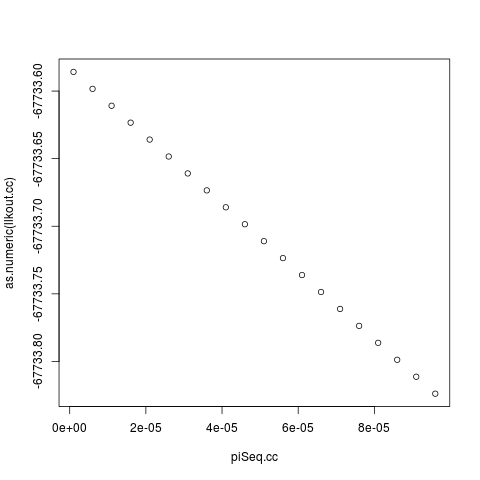

In [42]:
%%R
plot(piSeq.cc, as.numeric(llkout.cc))

###Combine case-control data

In [21]:
%%R
library('parallel')
piSeq1 <- seq(0.00001, 0.015, 0.0002)


llkout.cc <- mclapply(piSeq1, function(piX) logLikelihood(countData = counts, hyperpar = hyperpar,
                                      pi0 = piX, mutationData = data$mut.rate*mu.frac[1], 
                                                        testType = "both")$logLik)
                 



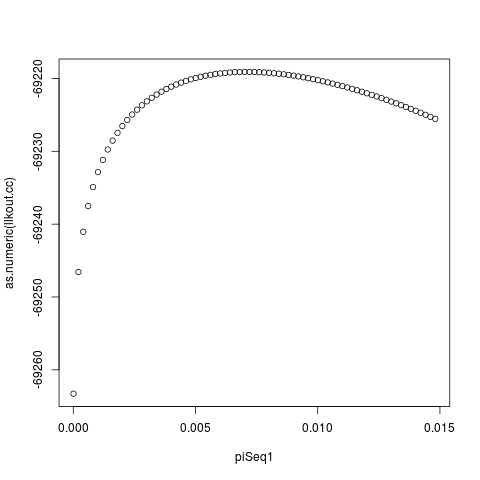

In [22]:
%%R
plot(piSeq1, as.numeric(llkout.cc))

###Write a function to calculate optimal values

In [58]:
%%R
#mutationData <- cbind(data$mut.rate*mu.frac[1])
mutationData <- cbind(data$mut.rate*mu.frac[1], data$mut.rate*mu.frac[2])

piFunc <- function(x){

    piX <- x[1]
    gamma.mean.dn.lof <- x[2]
    beta.dn.lof <- x[3]
    gamma.mean.dn.mis3 <- x[4]
    beta.dn.mis3 <- x[5]

    hyperparNew <- hyperpar
    hyperparNew[1, 1] <- gamma.mean.dn.lof
    hyperparNew[1, 2] <- gamma.mean.dn.mis3
    hyperparNew[2, 1] <- beta.dn.lof
    hyperparNew[2, 2] <- beta.dn.mis3

    log.All <- -logLikelihood(countData = counts, hyperpar = hyperparNew,
                                      pi0 = piX, mutationData = mutationData)$logLik
    return(log.All)
}

#R -e "install.packages(c('rjags'), repos='http://cran.rstudio.com/')"

###Optimize to obtain local optimization values for de novo data of LoF and mis3

In [19]:
%%R
library("optimx")
pi.M <- optimx(c(0.05, 20, 1, 5, 1), fn = piFunc,
               lower = c(0,   5, 0.01,   1, 0.01),
               upper = c(1, 100, 5.00, 100, 5.00))



In [20]:
%%R
pi.M

                 p1       p2         p3       p4 p5    value fevals gevals
L-BFGS-B 0.06362857 16.22064 0.04746113 5.043086  5 4502.795     56     56
         niter convcode kkt1 kkt2   xtimes
L-BFGS-B    NA        0 TRUE TRUE 8523.804


###Take a look at these gamma values

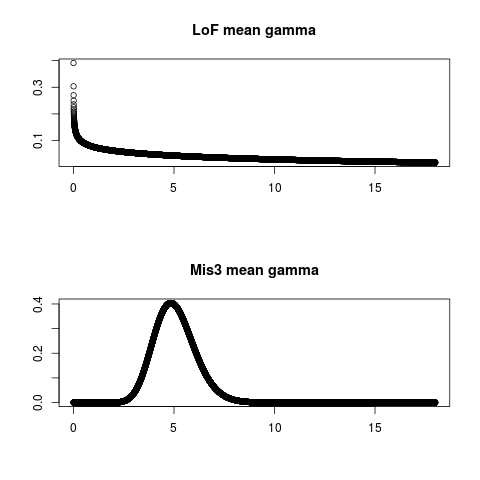

In [72]:
%%R
xGamma <- seq(0.001, 18, 0.002)
par(mfrow = c(2, 1))
plot(xGamma, dgamma(xGamma, 16.22064*0.04746113, rate = 0.04746113), main = 'LoF mean gamma', xlab = '', 
    ylab = '')
###Mis3 de novo
plot(xGamma, dgamma(xGamma, 5.043086*5, rate = 5), main = 'Mis3 mean gamma', xlab = '', ylab = '')


In [59]:
%%R
library("optimx")
pi.M.n <- optimx(c(0.05, 20, 1, 5, 1), fn = piFunc,
               lower = c(0,   5, 1,   1, 1),
               upper = c(1, 100, 5.00, 100, 1000))




#### Set a larger lower limit for beta => small pi

=> Number of risk genes = 32

In [60]:
%%R
pi.M.n

                 p1       p2 p3       p4       p5    value fevals gevals niter
L-BFGS-B 0.03894098 26.85295  1 6.605005 7.968401 4508.279     27     27    NA
         convcode kkt1  kkt2  xtimes
L-BFGS-B        0 TRUE FALSE 3415.53


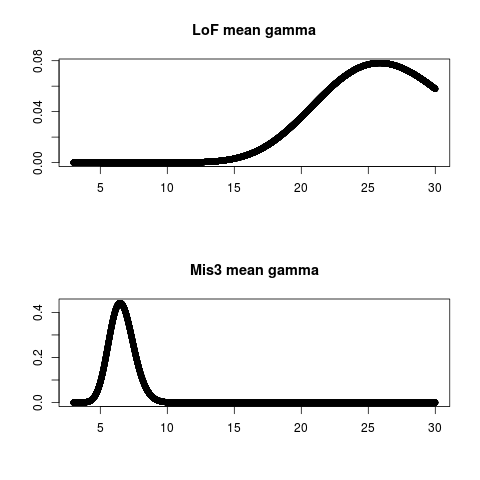

In [75]:
%%R
xGamma <- seq(3, 30, 0.002)
par(mfrow = c(2, 1))
plot(xGamma, dgamma(xGamma, 26.85295, rate =  1 ), main = 'LoF mean gamma', xlab = '', 
    ylab = '')
###Mis3 de novo
plot(xGamma, dgamma(xGamma, 6.605005*7.968401, rate = 7.968401), main = 'Mis3 mean gamma', xlab = '', ylab = '')



In [45]:
%%R
hyperpar

               [,1]   [,2]
gamma.mean.dn  20.0    4.7
beta.dn         1.0    1.0
gamma.mean.CC   2.3    1.0
beta.CC         4.0 1000.0
rho1            0.1    0.5
nu1           200.0  100.0
rho0            0.1    0.5
nu0           200.0  100.0


In [93]:
%%R
#mutationData <- cbind(data$mut.rate*mu.frac[1])
mutationData <- cbind(data$mut.rate*mu.frac[1], data$mut.rate*mu.frac[2])

piFunc.both <- function(x){

    piX <- x[1]
    
    ###De novo
    gamma.mean.dn.lof <- x[2]
    beta.dn.lof <- x[3]
    gamma.mean.dn.mis3 <- x[4]
    beta.dn.mis3 <- x[5]
    
    ###Case-control
    gamma.mean.cc.lof <- x[6]
    beta.cc.lof <- x[7]
    gamma.mean.cc.mis3 <- x[8]
    beta.cc.mis3 <- x[9]

    hyperparNew <- hyperpar
    hyperparNew[1, 1] <- gamma.mean.dn.lof
    hyperparNew[1, 2] <- gamma.mean.dn.mis3
    hyperparNew[2, 1] <- beta.dn.lof
    hyperparNew[2, 2] <- beta.dn.mis3
    
    hyperparNew[3, 1] <- gamma.mean.cc.lof
    hyperparNew[3, 2] <- gamma.mean.cc.mis3
    hyperparNew[4, 1] <- beta.cc.lof
    hyperparNew[4, 2] <- beta.cc.mis3

    log.All <- -logLikelihood(countData = counts, hyperpar = hyperparNew,
                                      pi0 = piX, 
                              testType = "both",
                              mutationData = mutationData)$logLik
    return(log.All)
}



In [49]:
%%R
library("optimx")
pi.M.both <- optimx(c(0.05, 
                      20, 1, 5, 1, 
                     2.3, 4, 1, 100), 
                    
                    fn = piFunc.both,
                    
               lower = c(0,   
                         5, 0.01,   1, 0.01,
                        1, 0.01, 1, 0.01),
               upper = c(1, 
                         100, 5.00, 100, 5.00,
                        100, Inf, 100, Inf))



In [50]:
%%R
pi.M.both

                  p1       p2         p3       p4        p5  p6 p7 p8  p9
L-BFGS-B 0.007696397 24.82885 0.02330943 15.55757 0.4347588 2.3  4  1 100
            value fevals gevals niter convcode kkt1  kkt2  xtimes
L-BFGS-B 183054.4     39     39    NA        0 TRUE FALSE 8067.23


In [94]:
%%R
library("optimx")
pi.M.both.n <- optimx(c(0.05, 
                      20, 1, 5, 1, 
                     2.3, 4, 1, 100), 
                    
                    fn = piFunc.both,
                    
               lower = c(0,   
                         5, 1, 1, 1,
                         1, 1, 1, 1),
               upper = c(1, 
                         100, 5.00, 100, 5.00,
                        100, Inf, 100, Inf))



In [95]:
#!gist -p Re_test_all_parameters_inTADA.ipynb

In [62]:
%%R
pi.M.both.n

                  p1       p2 p3       p4       p5  p6 p7 p8  p9    value
L-BFGS-B 0.007432505 26.53308  1 19.44955 1.062747 2.3  4  1 100 183062.2
         fevals gevals niter convcode kkt1  kkt2  xtimes
L-BFGS-B     20     20    NA        0 TRUE FALSE 4358.28


LoF protective proportion: 0
Mis3 protective proportion: 0.523743315508021


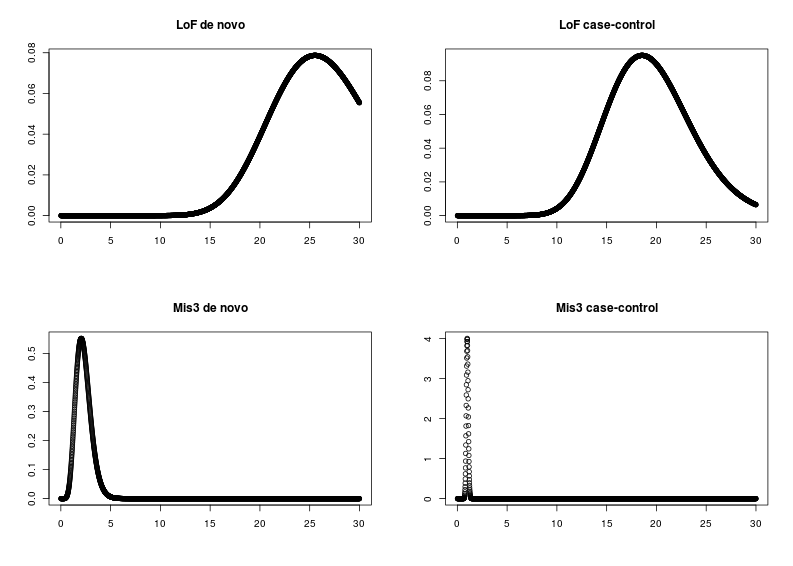

In [87]:
%%R -w 28 -h 20 -u cm
xT <- seq(0.01, 30, 0.01)
par(mfrow = c(2, 2))

plot(xT, dgamma(xT, 26.53*1, rate = 1), main = 'LoF de novo', xlab  = '', ylab = '')
plot(xT, dgamma(xT, 19.5*1.0627, rate = 1.0627), main = 'LoF case-control', xlab  = '', ylab = '')
plot(xT, dgamma(xT, 2.3*4, rate = 4), main = 'Mis3 de novo', xlab  = '', ylab = '')
plot(xT, dgamma(xT, 1*100, rate = 100), main = 'Mis3 case-control', xlab  = '', ylab = '')

NN <- 18700
x.cc.lof <- rgamma(NN, 19.44955*1.06274, rate = 1.06274)

message("LoF protective proportion: ", length(x.cc.lof[x.cc.lof < 1])/length(x.cc.lof))

x.cc.mis3 <- rgamma(NN, 1*100, rate = 100)

message("Mis3 protective proportion: ", length(x.cc.mis3[x.cc.mis3 < 1])/length(x.cc.mis3))





###Test $\rho, \nu$ on hyperparameters

The popultation frequency of the the mutant genotype: 

$q|H_j \sim Gamma(\rho_j, \nu_j)$

In [89]:
%%R
hyperpar

               [,1]   [,2]
gamma.mean.dn  20.0    4.7
beta.dn         1.0    1.0
gamma.mean.CC   2.3    1.0
beta.CC         4.0 1000.0
rho1            0.1    0.5
nu1           200.0  100.0
rho0            0.1    0.5
nu0           200.0  100.0


In [96]:
%%R
#mutationData <- cbind(data$mut.rate*mu.frac[1])
mutationData <- cbind(data$mut.rate*mu.frac[1], data$mut.rate*mu.frac[2])

piFunc.both <- function(x){

    piX <- x[1]
    
    ###De novo
    gamma.mean.dn.lof <- x[2]
    beta.dn.lof <- x[3]
    gamma.mean.dn.mis3 <- x[4]
    beta.dn.mis3 <- x[5]
    
    ###Case-control
    gamma.mean.cc.lof <- x[6]
    beta.cc.lof <- x[7]
    gamma.mean.cc.mis3 <- x[8]
    beta.cc.mis3 <- x[9]
    
    ###The popultation frequency of the the mutant genotype

    
    hyperparNew <- hyperpar
    hyperparNew[1, 1] <- gamma.mean.dn.lof
    hyperparNew[1, 2] <- gamma.mean.dn.mis3
    hyperparNew[2, 1] <- beta.dn.lof
    hyperparNew[2, 2] <- beta.dn.mis3
    
    hyperparNew[3, 1] <- gamma.mean.cc.lof
    hyperparNew[3, 2] <- gamma.mean.cc.mis3
    hyperparNew[4, 1] <- beta.cc.lof
    hyperparNew[4, 2] <- beta.cc.mis3

    log.All <- -logLikelihood(countData = counts, hyperpar = hyperparNew,
                                      pi0 = piX, 
                              testType = "both",
                              mutationData = mutationData)$logLik
    return(log.All)
}



In [14]:
#!gist -p Re_test_all_parameters_Test_differentMethods_of_Optimization.ipynb

In [15]:
!gist -u https://gist.github.com/cecbe988bb63efa7f488 Re_test_all_parameters_Test_differentMethods_of_Optimization.ipynb

https://gist.github.com/cecbe988bb63efa7f488
